In [1]:
from math import exp
from scipy.integrate import quad
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

figsize = (15,8)
legend_fontsize = 16

# Часть I: О теореме Байеса

### Вопрос 1:

Произошло убийство. На месте убийства найдена кровь, которая явно (будем считать, что с вероятностью 1) принадлежит настоящему убийце. Кровь принадлежит редкой группе, которая присутствует всего лишь у 1% населения. И так получилось, что у подсудимого как раз эта редкая группа крови!
<br>
<br>Первым выходит прокурор и говорит: “Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен -- всего 1%; значит, с вероятностью 99% он виновен, предлагаю осудить”. В чём не прав прокурор? Укажите, какие вероятности он оценил, а какие должен был оценить.

### Ответ:

<br> Обозначим события следующим образом:
<br> b (blood) - наличие редкой группы крови (b' - противоположное событие)
<br> c (criminal) - подсудимый виновен (c' - противоположное событие)
<br>
<br> Из условия известно:
<br> p(b) = 0.01
<br> p(b|c) = 1 // редкая группа крови с вероятностью 1 принадлежит убийце
<br>
<br> Прокурор говорит "Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен -- всего 1%".
<br> На языке вероятности это можно сказать так: "Вероятность иметь редкую группу крови, при условии, невиновности" или p(b|c').
<br> Из вопроса 2 известно, что число жителей в городе 10^6, тогда p(b|c') = p(b, c')/p(c') = 9999 / (10^6 - 1) = 0.00999901.
<br> Прокурору нужно было бы оценить долю убийц с редкой группой крови среди всех людей с редкой группой крови (на языке вероятности: вероятность, что человек с редкой кровью убийца, при условии редкой группы крови)

### Вопрос 2: 

Затем выходит адвокат, объясняет ошибки прокурора и берёт слово сам: “В городе живёт миллион человек. Это значит, что примерно у 10000 из них такая группа крови. Значит, всё, что говорит нам эта кровь -- это то, что подсудимый совершил убийство с вероятностью 0.01%. Получается, что это свидетельство не просто не является строгим доказательством, а и вовсе даёт нам ничтожно малую вероятность того, что мой подзащитный виновен, так что предлагаю исключить его из материалов дела”. В чём не прав адвокат? Какие вероятности он оценил, а какие должен был оценить?

### Ответ:

Из условия известно:
<br> n = 10^6 число жителей в городе
<br>
<br>Адвокат оценил p(c|b) = 1 / 10^4 = 0.0001 - вероятностьность, что подсудимый виновен при условии наличия редкой группы крови.
<br>Адвокат должен был оценить вероятность, что подсудимый убил жертву, при условии что жертва уже кем-то убита и убийца имеет редкую группу крови (по аналогии с делом O.J. Simpson, где нужно было оценить вероятность, что муж убил жену, при условии, что жена уже убита и муж ранее бил жену)

### Вопрос 3:

Вернёмся к тесту на страшную болезнь из первой лекции. Напомню, что по предположениям задачи болеет 1% населения, а тест имеет вероятность ошибки 5% в обе стороны. Мы видели, что в результате человек с положительным тестом имеет апостериорную вероятность оказаться больным всего лишь около 16%.
<br>
<br>Врачи решили, что терпеть это никак нельзя; они готовы провести срочное исследование и улучшить качество теста. Но сил и денег хватит только для того, чтобы сократить один тип ошибок, т.е. уменьшить или только число false positives (когда тест выдаёт положительный результат у здорового человека), или только число false negatives (когда тест выдаёт отрицательный результат у больного).
<br>
<br>Помогите медикам: постройте зависимости апостериорной вероятности болезни после положительного и отрицательного теста от обоих видов ошибок (например, в виде графиков), сделайте выводы и дайте рекомендации врачам -- на чём лучше сосредоточиться?


In [2]:
# test_result = 1, тест положительный
# test_result = 0, тест отрицательный
# p(d = 1 | t = 0) - ложно отрицательный результат FN
# p(d = 0 | t = 1) - ложно положительный результат FP

def compute_posterior(test_result, prior_prob=0.01, FN=0.05, FP=0.05):
    if test_result == 1:
        return (prior_prob * (1-FN)) / (prior_prob * (1-FN) + (1-prior_prob) * FP)
    elif test_result == 0:
        return (prior_prob * FN) / (prior_prob * FN + (1-FP) * (1-prior_prob))
    else:
        return None

xs = np.arange(0, 0.05, 0.001)

vector_posterior_FN = np.vectorize(compute_posterior, excluded=['test_result', 'prior_prob', 'FP'])
ys_one_FN = vector_posterior_FN(test_result=1, prior_prob=0.01, FN=xs, FP=0.5)
ys_zero_FN = vector_posterior_FN(test_result=0, prior_prob=0.01, FN=xs, FP=0.5)

vector_posterior_FP = np.vectorize(compute_posterior, excluded=['test_result', 'prior_prob', 'FN'])
ys_one_FP = vector_posterior_FP(test_result=1, prior_prob=0.01, FN=0.5, FP=xs)
ys_zero_FP = vector_posterior_FP(test_result=0, prior_prob=0.01, FN=0.5, FP=xs)

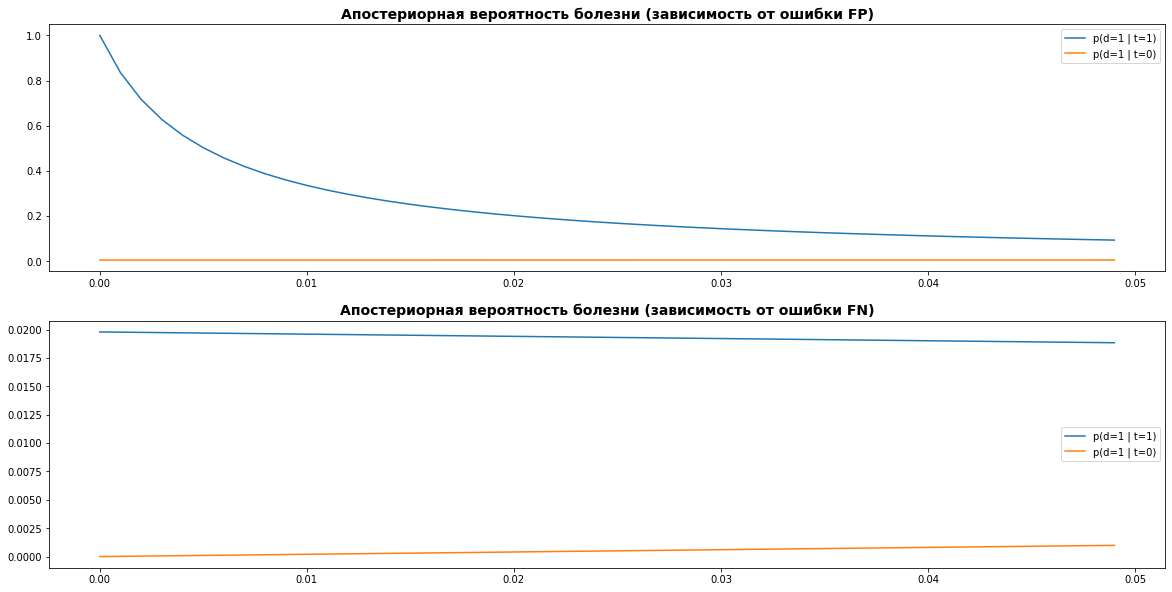

In [3]:
# поверхность
fig, [ax_fp, ax_fn] = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

# график FP
ax_fp.plot(xs, ys_one_FP, label='p(d=1 | t=1)')
ax_fp.plot(xs, ys_zero_FP, label='p(d=1 | t=0)')
ax_fp.set_title('Апостериорная вероятность болезни (зависимость от ошибки FP)', fontsize=14, fontweight='bold')
ax_fp.legend()

# график FN
ax_fn.plot(xs, ys_one_FN, label='p(d=1 | t=1)')
ax_fn.plot(xs, ys_zero_FN, label='p(d=1 | t=0)')
ax_fn.set_title('Апостериорная вероятность болезни (зависимость от ошибки FN)', fontsize=14, fontweight='bold')
ax_fn.legend()

plt.show()

<br> Из верхнего графика видно, что уменьшение ошибки FP достаточно быстро приводит к росту p(d=1 | t=1) - синяя линия.
<br> Из нижнего графика видно, что уменьшение ошибки FN ведет к незначительному уменьшению вероятности p(d=1 | t=0) - оранжевая линия.
<br> Поэтому правильнее уменьшать ошибку FP.

# Часть II: О линейной регресси

<br> https://ourworldindata.org/coronavirus-source-data

In [4]:
START_DATE =  pd.Timestamp(year=2020, month=3, day=3) 
OFFSET = 49
END_DATE = START_DATE + pd.DateOffset(days=OFFSET)

In [5]:
df = pd.read_csv('owid-covid-data.csv', parse_dates=['date'])

In [6]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [73]:
def prepare_dataset(source_df: pd.DataFrame, start_date: pd.Timestamp, end_date: pd.Timestamp) -> pd.DataFrame:
    df = source_df.copy()
    df = df[(df.iso_code == 'RUS') & (df.date >= start_date) & (df.date <= end_date)]
    df.loc[:, 'new_cases'] = df.new_cases.apply(lambda x: 1 if x <= 0 else x) # защита от 0
    df.loc[:, 'n_day'] = df.date.apply(lambda x: (x - START_DATE).days + 1)
    df.loc[:, 'n_day2'] = df.n_day * df.n_day
    df.loc[:, 'total_cases_log'] = np.log(df.total_cases) # target для экспоненциальное модели
    df.loc[:, 'total_cases_grad_log'] = np.gradient(df.total_cases) # target для сигмоидальной модели
    df.loc[:, 'total_cases_grad_log'] = df.total_cases_grad_log.apply(lambda x: 0.001 if (x == 0) else x) # защита от 0
    df.loc[:, 'total_cases_grad_log'] = np.log(df.total_cases_grad_log)
    df.set_index('date', drop=True, inplace=True)
    df = df[['n_day', 'n_day2', 'total_cases', 'total_cases_log', 'total_cases_grad_log']]
    return df

In [74]:
train_df = prepare_dataset(df, START_DATE, END_DATE)

In [75]:
train_df.head()

,n_day,n_day2,total_cases,total_cases_log,total_cases_grad_log
date,,,,,
2020-03-03,1,1,3.0,1.098612,-6.907755
2020-03-04,2,4,3.0,1.098612,-0.693147
2020-03-05,3,9,4.0,1.386294,1.609438
2020-03-06,4,16,13.0,2.564949,1.504077
2020-03-07,5,25,13.0,2.564949,0.693147


In [76]:
train_df.shape

(50, 5)

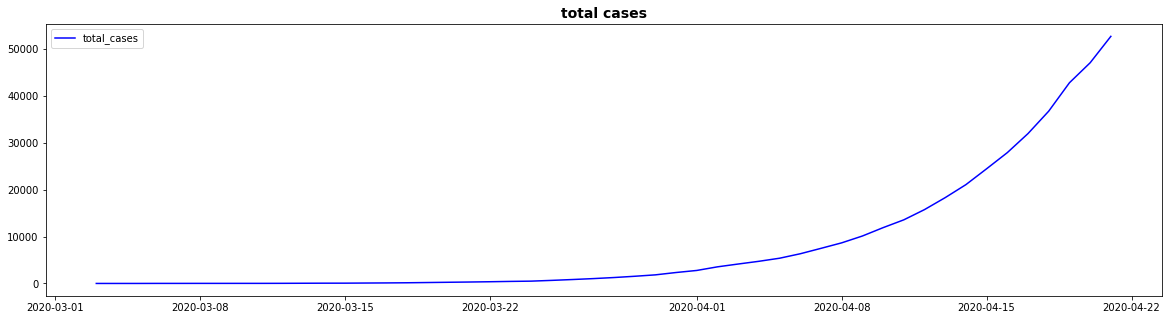

In [77]:
# figure
plt.figure(figsize=(20, 5)) 
ax = plt.axes() # Add an axes to the current figure and make it the current axes

# data
ax.plot(train_df.index, train_df.total_cases, label='total_cases', color='b')
#ax.plot(train_df.date, train_df.new_cases, label='new_cases')

# annotation  
ax.set_title('total cases', fontsize=14, fontweight='bold')
_ = ax.legend()

## 2. Предсказание с помощью экспоненциальной кривой

<br> y = exp(kx + b)  
<br> kx + b = log(y)

#### 2a Модель

In [78]:
train_df = prepare_dataset(df, START_DATE, END_DATE)
lambda_l2 = 1
lin_model = Ridge(alpha=lambda_l2).fit(train_df[['n_day']], train_df[['total_cases_log']])

In [79]:
print(f'Линейная модель с L2 регуляризацией:')
print(f'k={round(lin_model.coef_[0][0], 2)}')
print(f'b={round(lin_model.intercept_[0], 2)}')
print(f'lambda={lambda_l2}')

Линейная модель с L2 регуляризацией:
k=0.2
b=1.62
lambda=1


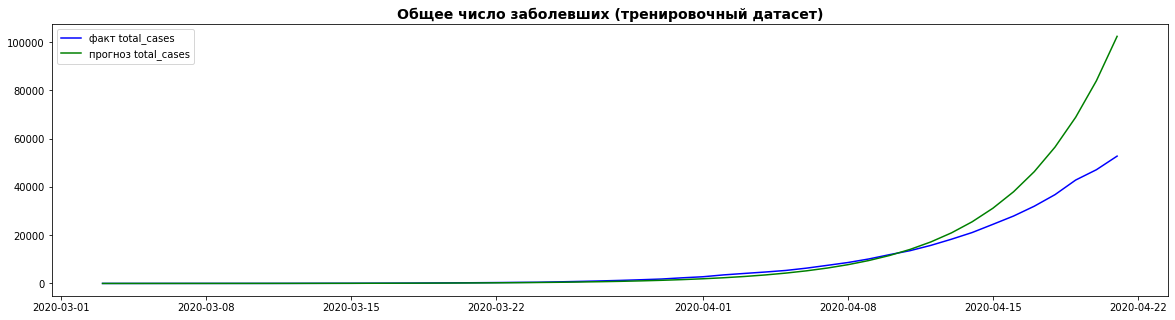

In [80]:
train_df['total_cases_log_pred'] = lin_model.predict(train_df[['n_day']])
train_df['total_cases_pred'] = train_df['total_cases_log_pred'].apply(lambda x: exp(x))

# figure
plt.figure(figsize=(20, 5)) 
ax = plt.axes() # Add an axes to the current figure and make it the current axes

# data
ax.plot(train_df.index, train_df.total_cases, label='факт total_cases', color='b')
ax.plot(train_df.index, train_df.total_cases_pred, label='прогноз total_cases', color='g')

# annotation  
ax.set_title('Общее число заболевших (тренировочный датасет)', fontsize=14, fontweight='bold')
_ = ax.legend()

#### 2b Определение апостериорного распределения параметров модели при условии имеющихся данных

Расчет апостериорных параметров распределения w:

<img src="pic/map_params1.png">

Априорные параметры дисперсии шума и дисперсии весов w (матрица ковариации):

![caption](./pic/map_params3.png)

In [81]:
train_df.loc[:, 'error'] = train_df.total_cases_log - train_df.total_cases_log_pred
sigma_eps_squared = train_df.error.var()
print(f'дисперсия шума в данных = {sigma_eps_squared}')

alpha = sigma_eps_squared / lambda_l2
sigma_w_prior = alpha * np.eye(2)
print(f'априорная матрица ковариации параметров w:')
print(sigma_w_prior)
mu_w_prior = np.zeros(2)

sigma_w_aposterior = np.linalg.inv(np.linalg.inv(sigma_w_prior) + 
                                   1 / sigma_eps_squared * np.dot(train_df.n_day, train_df.n_day))
mu_aposterior = np.dot(sigma_w_aposterior, (np.dot(np.linalg.inv(sigma_w_prior), mu_w_prior) + 
                                            1 / sigma_eps_squared * np.dot(train_df.n_day, train_df.total_cases_log)))

дисперсия шума в данных = 0.1243168745435167
априорная матрица ковариации параметров w:
[[0.12431687 0.        ]
 [0.         0.12431687]]


In [82]:
sigma_w_aposterior

array([[ 0.06215916, -0.06215771],
       [-0.06215771,  0.06215916]])

In [83]:
mu_aposterior

array([0.12323976, 0.12323976])

#### 2c Сэмплирование разных экспонент

lambda=0.01, k=0.1983, b=1.62
lambda=0.1, k=0.1983, b=1.62
lambda=1, k=0.1983, b=1.62
lambda=10, k=0.1981, b=1.63
lambda=100, k=0.1964, b=1.67
lambda=1000, k=0.1809, b=2.07


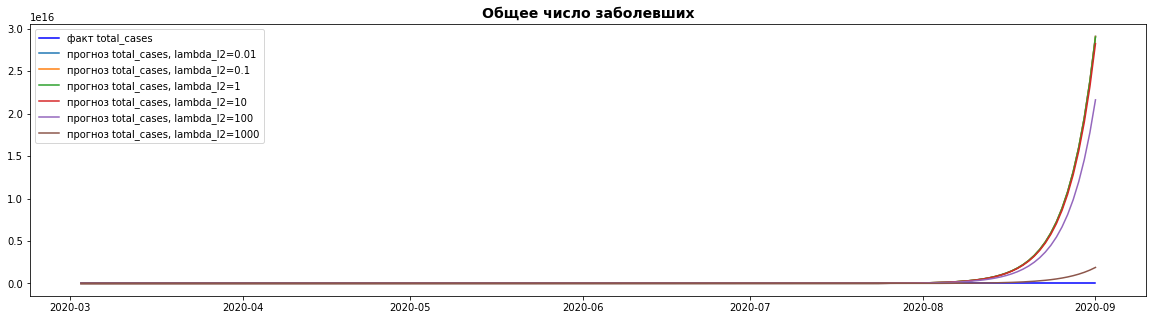

In [84]:
# test dataset
test_df = prepare_dataset(df, START_DATE, pd.Timestamp(year=2020, month=9, day=1))

# figure
plt.figure(figsize=(20, 5)) 
ax = plt.axes() # Add an axes to the current figure and make it the current axes
ax.plot(test_df.index, test_df.total_cases, label='факт total_cases', color='b')
ax.set_title('Общее число заболевших', fontsize=14, fontweight='bold')

for i in [0.01, 0.1, 1, 10, 100, 1000]:
    lambda_l2 = i
    lin_model = Ridge(alpha=lambda_l2).fit(train_df[['n_day']], train_df[['total_cases_log']])
    print(f'lambda={lambda_l2}, k={round(lin_model.coef_[0][0], 4)}, b={round(lin_model.intercept_[0], 2)}')
    
    # прогноз
    test_df[f'total_cases_log_pred_l2_{i}'] = lin_model.predict(test_df[['n_day']])
    test_df[f'total_cases_pred_l2_{i}'] = round(test_df[f'total_cases_log_pred_l2_{i}'].apply(lambda x: exp(x))).astype(int)

    # new line
    ax.plot(test_df.index, test_df.loc[:, f'total_cases_pred_l2_{i}'], label=f'прогноз total_cases, lambda_l2={i}')
    _ = ax.legend()

In [85]:
target_index = [pd.Timestamp(year=2020, month=5, day=1),
                pd.Timestamp(year=2020, month=6, day=1),
                pd.Timestamp(year=2020, month=9, day=1)]
target_cols = ['n_day', 'total_cases'] + [f'total_cases_pred_l2_{i}' for i in [0.01, 0.1, 1, 10, 100, 1000]]

In [86]:
# прогноз на 1 мая, 1 июня, 1 сентября
test_df.loc[target_index, target_cols]

,n_day,total_cases,total_cases_pred_l2_0.01,total_cases_pred_l2_0.1,total_cases_pred_l2_1,total_cases_pred_l2_10,total_cases_pred_l2_100,total_cases_pred_l2_1000
date,,,,,,,,
2020-05-01,60,114431.0,744073,744029,743589,739210,697199,408590
2020-06-01,91,414328.0,347719537,347680504,347290452,343417582,307310926,111425201
2020-09-01,183,997072.0,29104034449693316,29096179184404548,29017750492695944,28245721459215032,21624438785826552,1885818411265666


## 3. Предсказание с помощью кривой сигмоидального вида

<br>Взяв в качестве конкретной формы сигмоиды форму функции распределения для гауссиана сделаем следующие преобразования:
<br>1. коэффициент перед интегралом заменим на произвольный 
<br>2. внесем коэффициент перед интегралом под интеграл, а далее в степень экспоненты
<br>3. в качестве степени экспонены будет выступать произволный многочлен 2ой степени.
<br>4. приравняем полученную функцию к таргету
<br>Т.к. производная интеграла равна подынтегральной функции, то равенство из пункта 4 можно переписать следующим образом:
<br>a*t^2 + b*t + c = log(target')

#### 3a Модель

In [87]:
train_df = prepare_dataset(df, START_DATE, END_DATE)
lambda_l2 = 1
lin_model = Ridge(alpha=lambda_l2).fit(train_df[['n_day', 'n_day2']], train_df[['total_cases_grad_log']])

In [88]:
a = lin_model.coef_[0][0]
b = lin_model.coef_[0][1]
c = lin_model.intercept_[0]
print(f'Линейная модель с L2 регуляризацией:')
print(f'a={round(a, 2)}')
print(f'b={round(b, 2)}')
print(f'c={round(c, 2)}')
print(f'lambda={lambda_l2}')

Линейная модель с L2 регуляризацией:
a=0.38
b=-0.0
c=-1.78
lambda=1


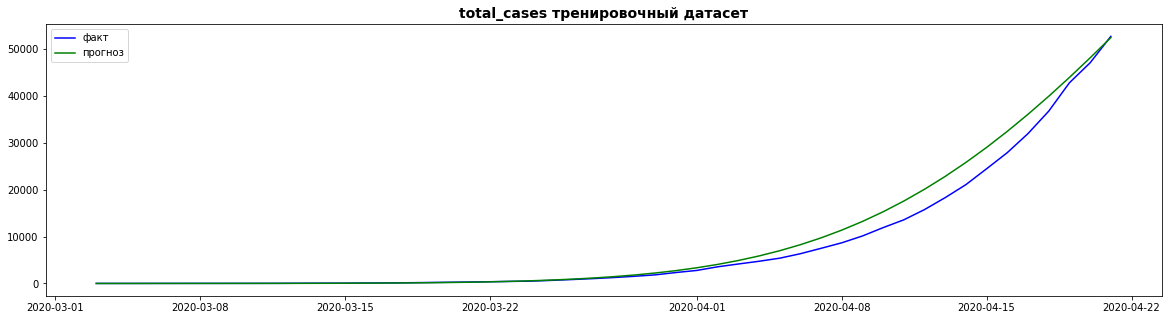

In [89]:
train_df['total_cases_grad_log_pred'] = lin_model.predict(train_df[['n_day', 'n_day2']])
train_df['total_cases_pred'] = np.cumsum(np.exp(train_df.total_cases_grad_log_pred))

# figure
plt.figure(figsize=(20, 5)) 
ax = plt.axes() # Add an axes to the current figure and make it the current axes

# data тотал прогноз производных
ax.plot(train_df.index, train_df.total_cases, label='факт', color='b')
ax.plot(train_df.index, train_df.total_cases_pred, label='прогноз', color='g')

# annotation  
ax.set_title('total_cases тренировочный датасет', fontsize=14, fontweight='bold')
_ = ax.legend()

#### 2b Определение апостериорного распределения параметров модели при условии имеющихся данных

In [90]:
train_df.loc[:, 'error'] = train_df.total_cases_grad_log - train_df.total_cases_grad_log_pred
sigma_eps_squared = train_df.error.var()
print(f'дисперсия шума в данных = {sigma_eps_squared}')

alpha = sigma_eps_squared / lambda_l2
sigma_w_prior = alpha * np.eye(3)
print(f'априорная матрица ковариации параметров w:')
print(sigma_w_prior)
mu_w_prior = np.zeros(3)

sigma_w_aposterior = np.linalg.inv(np.linalg.inv(sigma_w_prior) + 
                                   1 / sigma_eps_squared * np.dot(train_df.n_day, train_df.n_day))
mu_aposterior = np.dot(sigma_w_aposterior, (np.dot(np.linalg.inv(sigma_w_prior), mu_w_prior) + 
                                            1 / sigma_eps_squared * np.dot(train_df.n_day, train_df.total_cases_log)))

дисперсия шума в данных = 0.8837535333854404
априорная матрица ковариации параметров w:
[[0.88375353 0.         0.        ]
 [0.         0.88375353 0.        ]
 [0.         0.         0.88375353]]


#### 3c Сэмплирование разных сигмоид

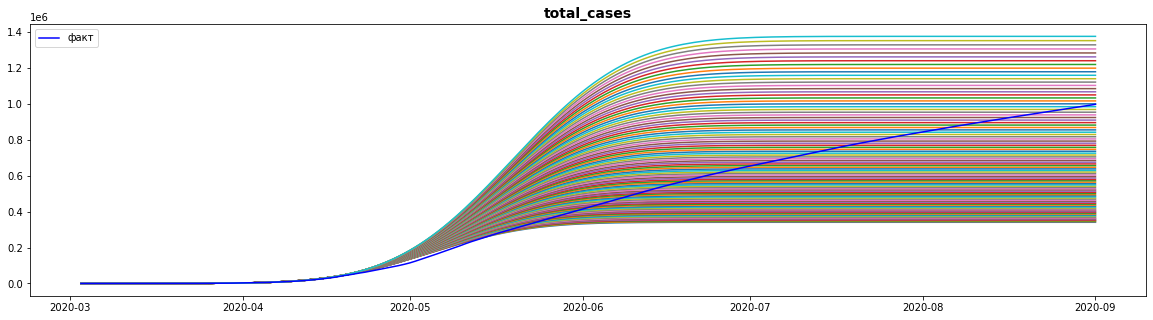

In [98]:
# test dataset
test_df = prepare_dataset(df, START_DATE, pd.Timestamp(year=2020, month=9, day=1))

# figure
plt.figure(figsize=(20, 5)) 
ax = plt.axes() # Add an axes to the current figure and make it the current axes

for i in range(100, 200):
    lambda_l2 = i
    lin_model = Ridge(alpha=lambda_l2).fit(train_df[['n_day', 'n_day2']], train_df[['total_cases_grad_log']])
#     print(f'lambda={lambda_l2}, a={round(lin_model.coef_[0][0], 4)}, \
#                                 b={round(lin_model.coef_[0][1], 4)}, \
#                                 c={round(lin_model.intercept_[0], 2)}')
    
    # прогноз
    test_df[f'total_cases_grad_log_pred_l2_{i}'] = lin_model.predict(test_df[['n_day', 'n_day2']])
    test_df[f'total_cases_pred_l2_{i}'] = np.cumsum(np.exp(test_df[f'total_cases_grad_log_pred_l2_{i}']))
    

    # new line
    ax.plot(test_df.index, test_df.loc[:, f'total_cases_pred_l2_{i}'])
    
ax.plot(test_df.index, test_df.total_cases, label='факт', color='b')
ax.set_title('total_cases', fontsize=14, fontweight='bold')
_ = ax.legend()

In [105]:
target_index = [pd.Timestamp(year=2020, month=5, day=1),
                pd.Timestamp(year=2020, month=6, day=1),
                pd.Timestamp(year=2020, month=9, day=1)]
basic_cols = ['n_day', 'total_cases']
target_cols = [f'total_cases_pred_l2_{i}' for i in range(100, 200)]

In [115]:
# прогноз на 1 мая, 1 июня, 1 сентября
result_df = test_df.loc[target_index, basic_cols + target_cols]
result_df['quantile10'] = round(result_df[target_cols].quantile(q=0.1, axis=1))
result_df['quantile90'] = round(result_df[target_cols].quantile(q=0.9, axis=1))

In [116]:
result_df[basic_cols + ['quantile10', 'quantile90']]

,n_day,total_cases,quantile10,quantile90
date,,,,
2020-05-01,60,114431.0,139466.0,178923.0
2020-06-01,91,414328.0,368690.0,941969.0
2020-09-01,183,997072.0,381517.0,1160858.0
